# <center>Kernelization</center>
**<center>Rendre les modèles linéaires non linéaires</center>**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Maps" data-toc-modified-id="Feature-Maps-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Maps</a></span></li><li><span><a href="#L'astuce-du-Kernel" data-toc-modified-id="L'astuce-du-Kernel-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>L'astuce du Kernel</a></span></li><li><span><a href="#Kernelisation" data-toc-modified-id="Kernelisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Kernelisation</a></span></li><li><span><a href="#Les-SVM-à-kernel-en-pratique" data-toc-modified-id="Les-SVM-à-kernel-en-pratique-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Les SVM à kernel en pratique</a></span></li><li><span><a href="#Le-théorème-du-représentant-(Representer-Theorem)" data-toc-modified-id="Le-théorème-du-représentant-(Representer-Theorem)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Le théorème du représentant (Representer Theorem)</a></span></li><li><span><a href="#Régression-Ridge-kernélisée" data-toc-modified-id="Régression-Ridge-kernélisée-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Régression Ridge kernélisée</a></span></li><li><span><a href="#Résumé" data-toc-modified-id="Résumé-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Résumé</a></span></li></ul></div>

![](https://miro.medium.com/v2/resize:fit:872/1*zWzeMGyCc7KvGD9X8lwlnQ.png)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Installation automatique lors de l'exécution sur Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Importations et paramètres globaux
%matplotlib inline
from preamble import *
interactive = True # Définir à True pour les tracés interactifs
if interactive:
    fig_scale = 1.5
else: # Pour l'affichage
    fig_scale = 0.3
    plt.rcParams.update(print_config)
    

## Feature Maps
* Modèles linéaires : $\hat{y} = \mathbf{w}\mathbf{x} + w_0 = \sum_{i=1}^{p} w_i x_i + w_0 = w_0 + w_1 x_1 + ... + w_p x_p $  

* Lorsque nous ne parvenons pas à ajuster correctement les données, nous pouvons ajouter des transformations non linéaires des caractéristiques.
* Application des variables (ou _expansion des bases_ ) $\phi$ : $ X \rightarrow \mathbb{R}^d $

$$y=\textbf{w}^T\textbf{x} \rightarrow y=\textbf{w}^T\phi(\textbf{x})$$

* Par exemple, application polynômiale des variables : tous les polynômes jusqu'au degré $d$ et tous les produits

$$[1, x_1, ..., x_p] \xrightarrow{\phi} [1, x_1, ..., x_p, x_1^2, ..., x_p^2, ..., x_p^d, x_1 x_2, ..., x_{p-1} x_p]$$ 

* Exemple avec $p=1, d=3$ :

$$y=w_0 + w_1 x_1 \xrightarrow{\phi} y=w_0 + w_1 x_1 + w_2 x_1^2 + w_3 x_1^3$$.  

### Exemple de régression Ridge

Weights: [0.418]


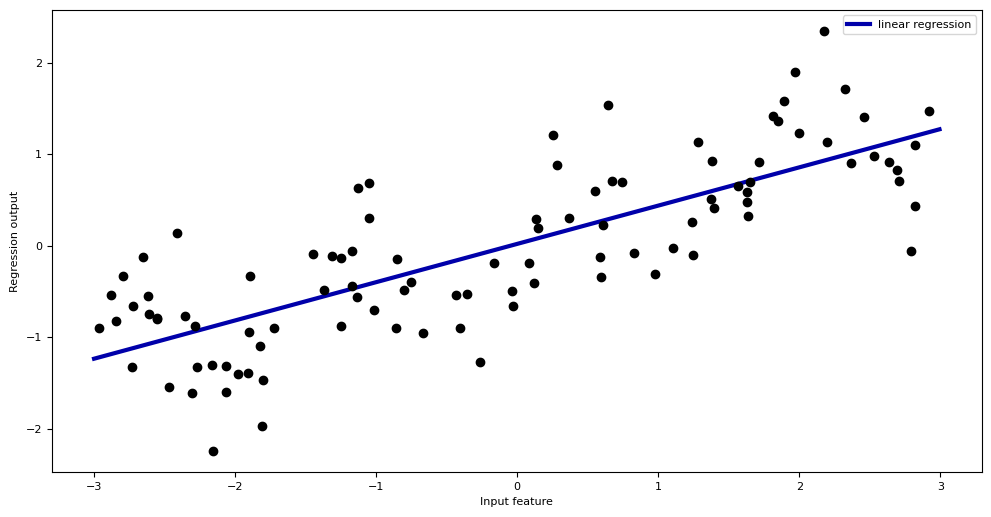

In [3]:
from sklearn.linear_model import Ridge

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
reg = Ridge().fit(X, y)
print("Weights:",reg.coef_)
fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
plt.plot(line, reg.predict(line), label="linear regression", lw=2*fig_scale)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

* Ajouter tous les polynômes $x^d$ jusqu'au degré 10 et ajuster à nouveau :
    * par exemple, utiliser sklearn `PolynomialFeatures`

In [4]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)
styles = [dict(selector="td", props=[("font-size", "150%")]),dict(selector="th", props=[("font-size", "150%")])]
pd.DataFrame(X_poly, columns=poly.get_feature_names_out()).head().style.set_table_styles(styles)

,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,x0^10
0,-0.752759,0.566647,-0.426548,0.321088,-0.241702,0.181944,-0.136960,0.103098,-0.077608,0.058420
1,2.704286,7.313162,19.776880,53.482337,144.631526,391.124988,1057.713767,2860.360362,7735.232021,20918.278410
2,1.391964,1.937563,2.697017,3.754150,5.225640,7.273901,10.125005,14.093639,19.617834,27.307312
3,0.591951,0.350406,0.207423,0.122784,0.072682,0.043024,0.025468,0.015076,0.008924,0.005283
4,-2.063888,4.259634,-8.791409,18.144485,-37.448187,77.288869,-159.515582,329.222321,-679.478050,1402.366700


Weights: [ 0.643  0.297 -0.69  -0.264  0.41   0.096 -0.076 -0.014  0.004  0.001]


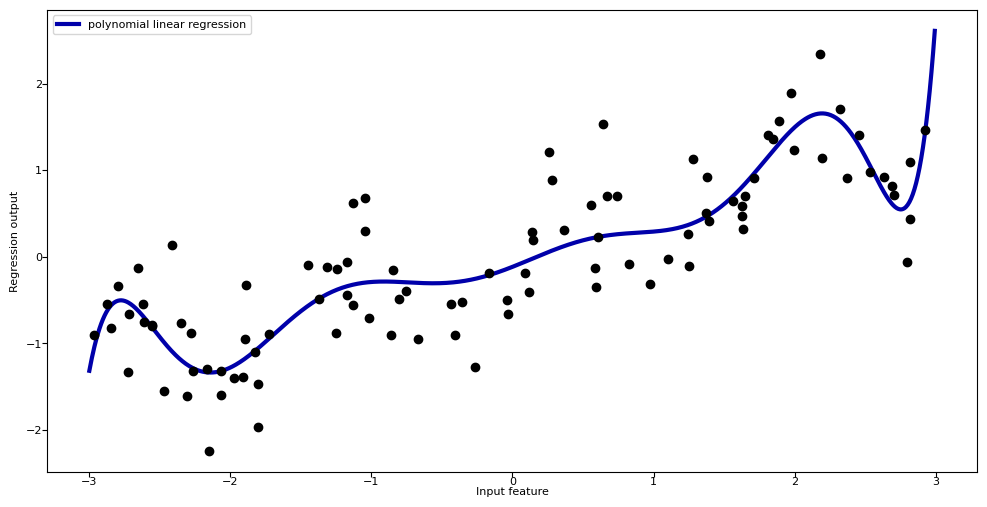

In [5]:
reg = Ridge().fit(X_poly, y)
print("Weights:",reg.coef_)
line_poly = poly.transform(line)
fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression', lw=2*fig_scale)
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature", labelpad=0.1)
plt.tick_params(axis='both', pad=0.1)
plt.legend(loc="best");

#### Quel est le coût de cette solution ?

* Vous pouvez avoir besoin de BEAUCOUP de dimensions pour entraîner les données.
    * Coût de la mémoire et du calcul
    * Plus de poids à apprendre, plus de risques de surapprentissage
    
* Ridge a une solution de forme fermée que nous pouvons calculer à l'aide de l'algèbre linéaire :

$$w^{*} = (X^{T}X + \alpha I)^{-1} X^T Y$$

* Puisque X a $n$ lignes (exemples), et $d$ colonnes (caractéristiques), $X^{T}X$ a une dimensionalité de $d x d$.
* Ridge est donc quadratique dans le nombre de caractéristiques, $\mathcal{O}(d^2n)$.
* Après l'application de la fonction des variables $\Phi$, nous obtenons
$$w^{*} = (\Phi(X)^{T}\Phi(X) + \alpha I)^{-1} \Phi(X)^T Y$$

* Puisque $\Phi$ augmente beaucoup $d$, $\Phi(X)^{T}\Phi(X)$ devient _énorme_

### Exemple de SVM linéaire (classification)

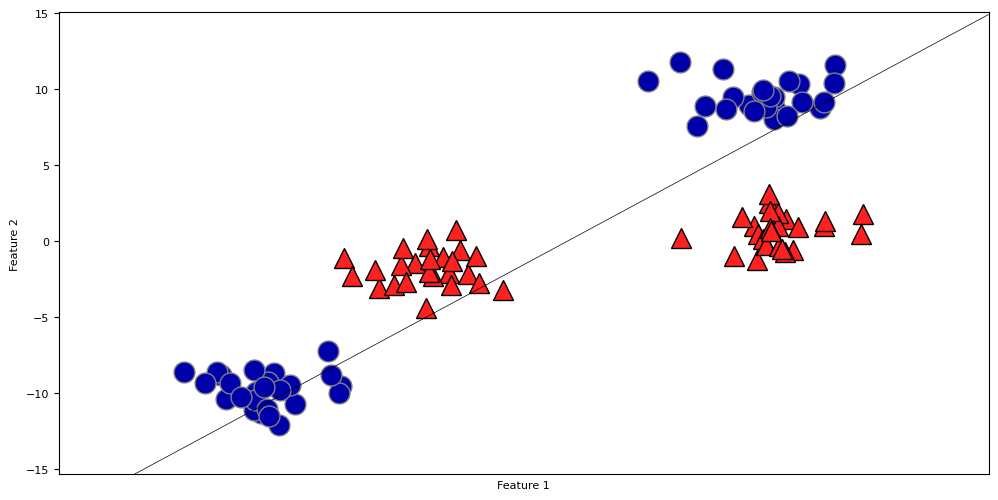

In [6]:
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
linear_svm = LinearSVC().fit(X, y)

fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, s=10*fig_scale)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

Nous pouvons ajouter une nouvelle caractéristique en prenant les carrés des valeurs de la caractéristique 1

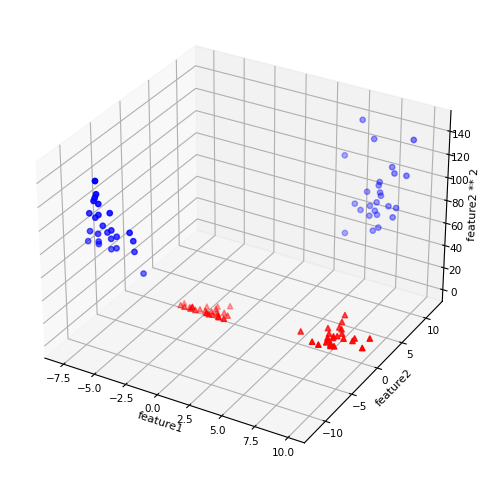

In [7]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])

# visualize in 3D
fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
ax = fig.add_subplot(111, projection='3d')

# plot first all the points with y==0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=10*fig_scale)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=10*fig_scale)
ax.set_xlabel("feature1", labelpad=-9)
ax.set_ylabel("feature2", labelpad=-9)
ax.set_zlabel("feature2 ** 2", labelpad=-9);
ax.tick_params(axis='both', width=0, labelsize=5*fig_scale, pad=-3)

Nous pouvons maintenant entraîner un modèle linéaire

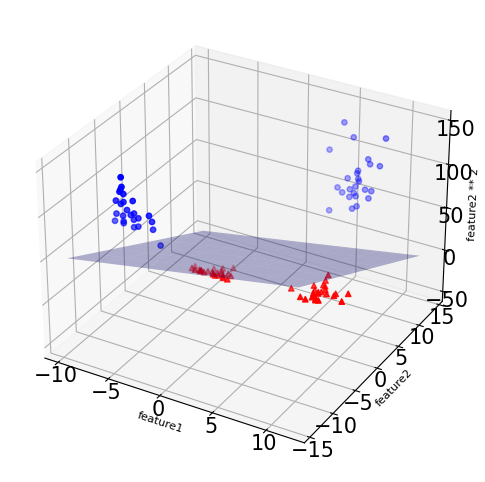

In [8]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
ax = fig.add_subplot(111, projection='3d')
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=10*fig_scale)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=10*fig_scale)

ax.set_xlabel("feature1", labelpad=-9)
ax.set_ylabel("feature2", labelpad=-9)
ax.set_zlabel("feature2 ** 2", labelpad=-9);
ax.tick_params(axis='both', width=0, labelsize=10*fig_scale, pad=-6)

En fonction des variables d'origine, la frontière de décision est également un polynôme
$$y = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_2^2 > 0$$.

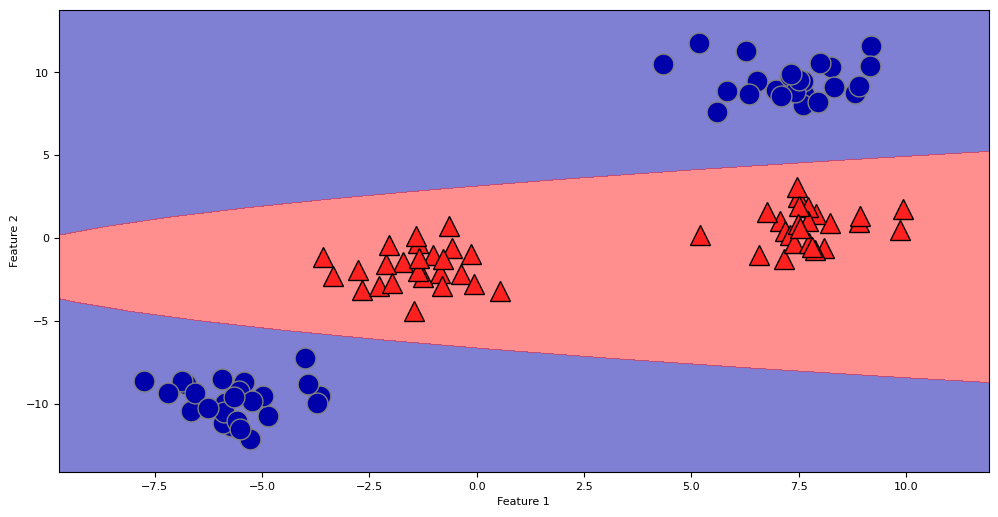

In [9]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
figure = plt.figure(figsize=(8*fig_scale,4*fig_scale))
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, s=10*fig_scale)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2"); 

## L'astuce du Kernel
* Les calculs dans les applications de variables explicites à haute dimension sont _coûteux_.
* Pour _certaines_ applications/fonctions de variables, nous pouvons cependant calculer des _distances_ entre _points_ à peu de frais
    * Sans construire explicitement l'espace à haute dimension.
* Exemple : Application de variables quadratiques pour $\mathbf{x} = (x_1,..., x_p )$ :

$$ \Phi(\mathbf{x}) = (x_1,..., x_p , x_1^2,..., x_p^2 , \sqrt{2} x_1 x_2 , ..., \sqrt{2} x_{p-1} x_{p}) $$

* Une _fonction kernel_ existe pour cette application de caractéristiques afin de calculer les produits points

$$ k_{quad}(\mathbf{x_i},\mathbf{x_j}) = \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j}) = \mathbf{x_i} \cdot \mathbf{x_j} + (\mathbf{x_i} \cdot \mathbf{x_j})^2$$.

* Sauter le calcul de $\Phi(x_i)$ et $\Phi(x_j)$ et calculer directement $k(x_i,x_j)$.

## Kernelisation

* Kernel $k$ correspondant à une fonction de caractéristiques $\Phi$ : $ k(\mathbf{x_i},\mathbf{x_j}) = \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j})$
* Calcul du produit de points entre $x_i,x_j$ dans un espace à haute dimension $\mathcal{H}$.
    * Les kernels sont parfois appelés _produits scalaires généralisés_.
    * $\mathcal{H}$ est appelé _espace de Hilbert à noyau reproducteur_ (RKHS)
* Le produit scalaire est une mesure de la _similarité_ entre $x_i,x_j$.
    * Par conséquent, un noyau peut être considéré comme une mesure de similarité pour les espaces à haute dimension.
* Si nous avons une fonction de perte basée sur les produits scalaires $\mathbf{x_i}\cdot\mathbf{x_j}$, elle peut être _kernelisée_
    * Il suffit de remplacer les produits scalaires par $k(\mathbf{x_i},\mathbf{x_j})$.

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/RKHS.png" alt="ml" style="margin: 0 auto; width: 900px;"/>

### Exemple: SVMs

* SVM linéaires (forme duale, pour $l$ vecteurs de support avec des coefficients duaux $a_i$ et des classes $y_i$) :
$$\mathcal{L}_{Dual} (a_i) = \sum_{i=1}^{l} a_i - \frac{1}{2} \sum_{i,j=1}^{l} a_i a_j y_i y_j (\mathbf{x_i} . \mathbf{x_j}) $$
* SVM qvec kernel, en utilisant le kernel existant $k$ de notre choix :
$$\mathcal{L}_{Dual} (a_i, k) = \sum_{i=1}^{l} a_i - \frac{1}{2} \sum_{i,j=1}^{l} a_i a_j y_i y_j k(\mathbf{x_i},\mathbf{x_j}) $$

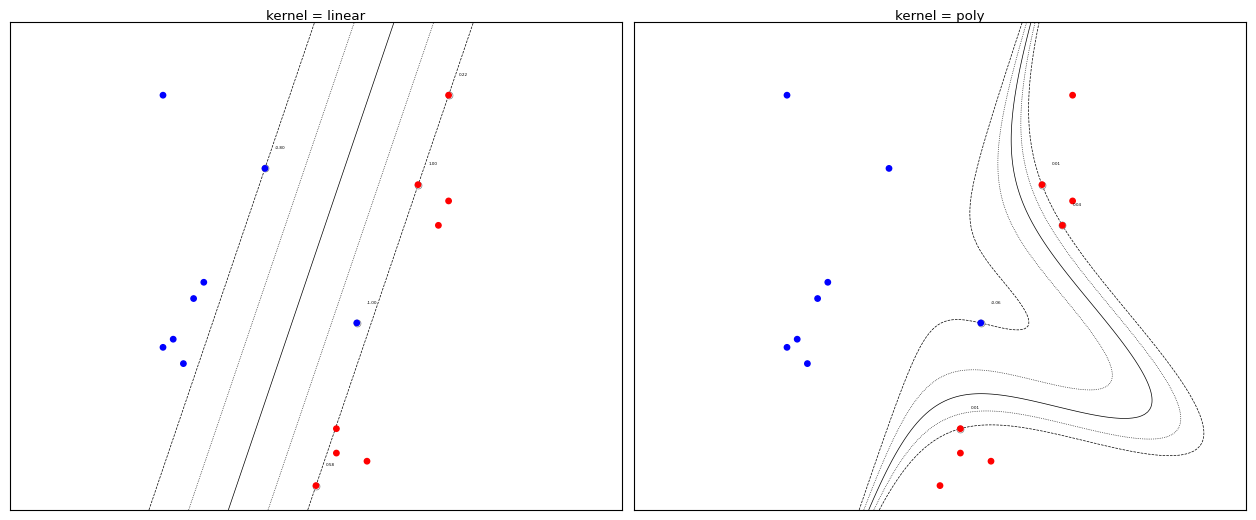

In [10]:
from sklearn import svm

def plot_svm_kernels(kernels, poly_degree=3, gamma=2, C=1, size=4):
    # Our dataset and targets
    X = np.c_[(.4, -.7),
              (-1.5, -1),
              (-1.4, -.9),
              (-1.3, -1.2),
              (-1.1, -.2),
              (-1.2, -.4),
              (-.5, 1.2),
              (-1.5, 2.1),
              (1, 1),
              # --
              (1.3, .8),
              (1.2, .5),
              (.2, -2),
              (.5, -2.4),
              (.2, -2.3),
              (0, -2.7),
              (1.3, 2.1)].T
    Y = [0] * 8 + [1] * 8

    # figure number
    fig, axes = plt.subplots(-(-len(kernels)//3), min(len(kernels),3), figsize=(min(len(kernels),3)*size*1.2*fig_scale, -(-len(kernels)//3)*size*fig_scale), tight_layout=True)
    if len(kernels) == 1:
        axes = np.array([axes])
    if not isinstance(gamma,list):
        gamma = [gamma]*len(kernels)
    if not isinstance(C,list):
        C = [C]*len(kernels)
    # fit the model
    for kernel, ax, g, c in zip(kernels,axes.reshape(-1),gamma,C):
        clf = svm.SVC(kernel=kernel, gamma=g, C=c, degree=poly_degree)
        clf.fit(X, Y)

        # plot the line, the points, and the nearest vectors to the plane
        if kernel == 'rbf':
            ax.set_title(r"kernel = {}, $\gamma$={}, C={}".format(kernel, g, c), pad=0.1)
        else:
            ax.set_title('kernel = %s' % kernel,pad=0.1)

        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                    s=25, edgecolors='grey', c='w', zorder=10, linewidths=0.5)
        ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.bwr, s=10*fig_scale)

        for i, coef in enumerate(clf.dual_coef_[0]):
            ax.annotate("%0.2f" % (coef), (clf.support_vectors_[i, 0]+0.1,clf.support_vectors_[i, 1]+0.25), zorder=11, fontsize=3)

        ax.axis('tight')
        x_min = -3
        x_max = 3
        y_min = -3
        y_max = 3

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        #plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.bwr, alpha=0.1)
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k', 'k', 'k'], linestyles=['--', ':', '-', ':', '--'],
                    levels=[-1, -0.5, 0, 0.5, 1])

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
plot_svm_kernels(['linear', 'poly'],poly_degree=3,size=3.5)

### Quels sont les kernels existants ?

* Un kernel (Mercer) est une fonction $k : X \times X \rightarrow \mathbb{R}$ avec les propriétés suivantes :
    - Symétrie : $k(\mathbf{x_1},\mathbf{x_2}) = k(\mathbf{x_2},\mathbf{x_1}) \quad \forall \mathbf{x_1},\mathbf{x_2} \in X$
    - Définie positive : la matrice du kernel $K$ est semi-définie positive.
        - Intuitivement, $k(\mathbf{x_1},\mathbf{x_2}) \geq 0$
        
* La matrice kernel (ou matrice de Gram) pour $n$ points de $x_1,..., x_n \ dans X$ est définie comme suit :

$$ K = XX^T = \begin{bmatrix}
                    k(\mathbf{x_1}, \mathbf{x_1}) & \ldots & k(\mathbf{x_1}, \mathbf{x_n}) \\
                    \vdots & \ddots & \vdots \\ 
                    k(\mathbf{x_n}, \mathbf{x_1}) & \ldots & k(\mathbf{x_n}, \mathbf{x_n})
                  \end{bmatrix}
                  $$
                  
* Une fois calculée ($\mathcal{O}(n^2)$), il suffit de rechercher $k(\mathbf{x_1}, \mathbf{x_2})$ pour deux points quelconques.
* En pratique, vous pouvez soit fournir une fonction kernel, soit précalculer la matrice kernel.

### Kernel linéaire
* L'espace d'entrée est le même que l'espace de sortie : $X = \mathcal{H} = \mathbb{R}^d$
* Application des caractéristiques $\Phi(\mathbf{x}) = \mathbf{x}$ 
* Kernel : $ k_{linear}(\mathbf{x_i},\mathbf{x_j}) = \mathbf{x_i} \cdot \mathbf{x_j}$
* Géométriquement, le produit scalaire est la _projection_ de $\mathbf{x_j}$ sur l'hyperplan défini par $\mathbf{x_i}$.
    * Il devient plus important si $\mathbf{x_i}$ et $\mathbf{x_j}$ sont dans la même "direction".
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/05_dotproduct.png" alt="ml" style="margin: 0 auto; width: 300px;"/>

* Kernel linéaire entre le point (0,1) et un autre vecteur unitaire d'un angle $a$ (en radians)
    * Les points ayant des angles similaires sont considérés comme similaires

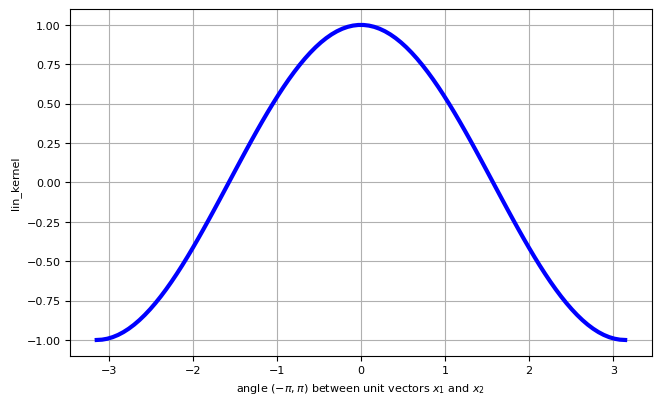

In [11]:
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
import math
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def plot_lin_kernel():
    fig, ax = plt.subplots(figsize=(5*fig_scale,3*fig_scale))
    x = np.linspace(-math.pi,math.pi,100)
    # compare point (0,1) with unit vector at certain angle
    # linear_kernel returns the kernel matrix, get first element
    ax.plot(x,[linear_kernel([[1,0]], [[math.cos(i),math.sin(i)]])[0] for i in x],lw=2*fig_scale,c='b',label='', linestyle='-')
    ax.set_xlabel("angle $(-\pi,\pi)$ between unit vectors $x_1$ and $x_2$")
    ax.set_ylabel("lin_kernel")
    plt.grid()
plot_lin_kernel()

### Kernel polynomial
- Si $k_1$, $k_2$ sont des kernels, alors $\lambda . k_1$ ($\lambda \geq 0$), $k_1 + k_2$, et $k_1 . k_2$ sont également des kernels.
- Le __kernel polynomial__ (pour le degré $d dans \mathbb{N}$) reproduit l'application de caractéristiques polynomiales.
    - $\gamma$ est un hyperparamètre de mise à l'échelle (par défaut $\frac{1}{p}$)
    - $c_0$ est un hyperparamètre (par défaut 1) pour compenser l'influence des termes d'ordre supérieur
$$k_{poly}(\mathbf{x_1},\mathbf{x_2}) = (\gamma (\mathbf{x_1} \cdot \mathbf{x_2}) + c_0)^d$$

In [12]:
@interact
def plot_poly_kernel(degree=(1,10,1), coef0=(0,2,0.5), gamma=(0,2,0.5)):
    fig, ax = plt.subplots(figsize=(5*fig_scale,3*fig_scale))
    x = np.linspace(-math.pi,math.pi,100)
    # compare point (0,1) with unit vector at certain angle
    if isinstance(degree,list):
        for d in degree:
            ax.plot(x,[polynomial_kernel([[1,0]], [[math.cos(i),math.sin(i)]], degree=d, coef0=coef0, gamma=gamma)[0]
                       for i in x],lw=2*fig_scale,label='degree = {}'.format(d), linestyle='-')    
    else:
        ax.plot(x,[polynomial_kernel([[1,0]], [[math.cos(i),math.sin(i)]], degree=degree, coef0=coef0, gamma=gamma)[0]
                   for i in x],lw=2*fig_scale,c='b',label='degree = {}'.format(degree), linestyle='-')    
    ax.set_xlabel("angle $(-\pi,\pi)$ between unit vectors $x_1$ and $x_2$")
    ax.set_ylabel("poly_kernel")
    plt.grid()
    plt.legend()

interactive(children=(IntSlider(value=5, description='degree', max=10, min=1), FloatSlider(value=1.0, descript…

In [13]:
if not interactive:
    plot_poly_kernel(degree=[2,3,5], coef0=1, gamma=None)

### Kernel RBF (gaussien)
- L'application de caractéristiques de la _Fonction de base radiale_ (RBF) est liée au développement de la série de Taylor de $e^x$
$$\Phi(x) = e^{-x^2/2\gamma^2} \Big[ 1, \sqrt{\frac{1}{1!\gamma^2}}x,\sqrt{\frac{1}{2!\gamma^4}}x^2,\sqrt{\frac{1}{3!\gamma^6}}x^3,\ldots\Big]^T$$

- Kernel RBF (ou _Gaussien ) avec _largeur du kernel_ $\gamma \geq 0$ :    
$$k_{RBF}(\mathbf{x_1},\mathbf{x_2}) = exp(-\gamma ||\mathbf{x_1} - \mathbf{x_2}||^2)$$ 

In [14]:
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_rbf_kernel(gamma=(0.01,10,0.1)):
    fig, ax = plt.subplots(figsize=(4*fig_scale,2.5*fig_scale))
    x = np.linspace(-6,6,100)
    if isinstance(gamma,list):
        for g in gamma:
            ax.plot(x,[rbf_kernel([[i]], [[0]], gamma=g)[0] for i in x],lw=2*fig_scale,label='gamma = {}'.format(g), linestyle='-')
    else:
        ax.plot(x,[rbf_kernel([[i]], [[0]], gamma=gamma)[0] for i in x],lw=2*fig_scale,c='b',label='gamma = {}'.format(gamma), linestyle='-')
    ax.set_xlabel("x (distance )",labelpad=0.1)
    ax.set_ylabel("rbf_kernel(0,x)")
    ax.set_ylim(0,1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid()

interactive(children=(FloatSlider(value=4.91, description='gamma', max=10.0, min=0.01), Output()), _dom_classe…

Développement de Taylor : plus nous ajoutons de composants, plus nous pouvons approximer une fonction.

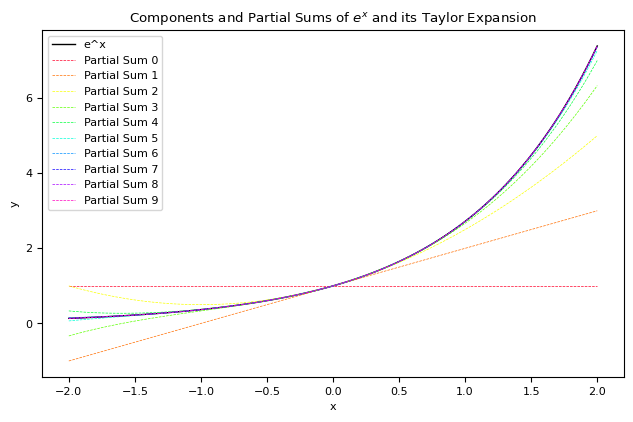

In [15]:
import matplotlib.cm as cm

# Generate x values
x = np.linspace(-2, 2, 100)

# Calculate corresponding y values for e^x
y_actual = np.exp(x)

# Plot the actual function
fig, ax = plt.subplots(figsize=(5*fig_scale,3*fig_scale))
plt.plot(x, y_actual, label='e^x', linewidth=1, color='black')

# Plot the individual terms of the Taylor expansion with formulas in the legend
colors = cm.gist_rainbow(np.linspace(0, 1, 10))  # Color scheme from red to blue
for n in range(10):
    term = x**n / np.math.factorial(n)
    partial_sum = np.sum([x**i / np.math.factorial(i) for i in range(n + 1)], axis=0)
    
    # Plot partial sums with different colors
    plt.plot(x, partial_sum, label=f'Partial Sum {n}', linestyle='dashed', color=colors[n])

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Components and Partial Sums of $e^x$ and its Taylor Expansion')

# Display legend
plt.legend();

In [16]:
if not interactive:
    plot_rbf_kernel(gamma=[0.1,0.5,10])

* Le kernel RBF $k_{RBF}(\mathbf{x_1},\mathbf{x_2}) = exp(-\gamma ||\mathbf{x_1} - \mathbf{x_2}|^2)$ n'utilise pas de produit scalaire.
    * Il ne prend en compte que la distance entre $\mathbf{x_1}$ et $\mathbf{x_2}$.
    * C'est un _kernel local_ : chaque point de données n'influence que les points de données voisins.
        * Les kernels linéaires et polynomiaux sont _globaux_ : chaque point affecte l'ensemble de l'espace.
    * La similarité dépend de la proximité des points et de la largeur du kernel.
        * La valeur augmente pour les points les plus proches et les kernels les plus larges (chevauchement plus important).

In [17]:
def gaussian(x, mu, gamma):
    k=2 # Doubling the distance makes the figure more interpretable
    return np.exp(-gamma * np.power((x - mu)*k, 2.))

@interact
def plot_rbf_kernel_value(gamma=(0.1,1,0.1),x_1=(-6,6,0.1),x_2=(-6,6,0.1)):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    x = np.linspace(-6,6,100)
    ax.plot(x,gaussian(x, x_1, gamma),lw=2*fig_scale,label='gaussian at x_1'.format(gamma), linestyle='-')
    ax.plot(x,gaussian(x, x_2, gamma),lw=2*fig_scale,label='gaussian at x_2'.format(gamma), linestyle='-')
    ax.plot(x,[rbf_kernel([[x_1]], [[x_2]], gamma=gamma)[0]]*len(x),lw=2,c='g',label='rfb_kernel(x_1,x_2)', linestyle='-')
    ax.set_xlabel("x")
    ax.set_ylabel(r"rbf_kernel($\gamma$={})".format(gamma))
    ax.set_ylim(0,1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid()

interactive(children=(FloatSlider(value=0.5, description='gamma', max=1.0, min=0.1), FloatSlider(value=0.0, de…

In [18]:
if not interactive:
    plot_rbf_kernel_value(gamma=0.2,x_1=0,x_2=2)

## Les SVM à kernel en pratique
* Vous pouvez utiliser les SVM avec n'importe quel kernel pour apprendre des limites de décision non linéaires.

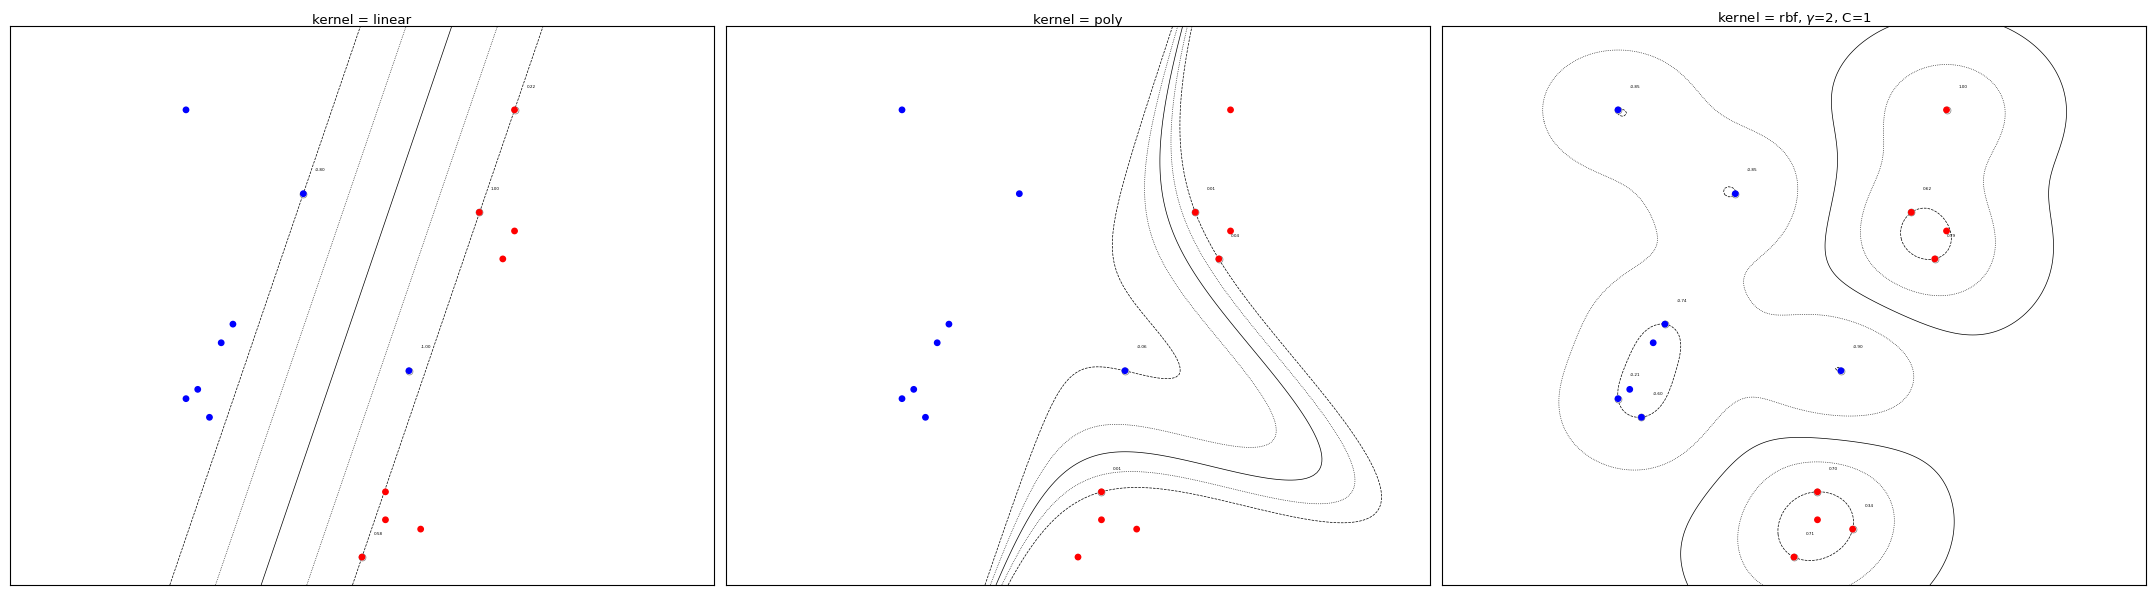

In [19]:
plot_svm_kernels(['linear', 'poly', 'rbf'],poly_degree=3,gamma=2,size=4)

### SVM avec kernel RBF
* Chaque vecteur de support influence _localement_ les prédictions, en fonction de la largeur du kernel ($\gamma$).
* La prédiction pour le point de test $\mathbf{u}$ : somme de l'influence restante de chaque vecteur de support
    * $f(x) = \sum_{i=1}^{l} a_i y_i k(\mathbf{x_i},\mathbf{u})$

In [20]:
@interact
def plot_rbf_data(gamma=(0.1,10,0.5),C=(0.01,5,0.1)):
    plot_svm_kernels(['rbf'],gamma=gamma,C=C,size=5)

interactive(children=(FloatSlider(value=4.6, description='gamma', max=10.0, min=0.1, step=0.5), FloatSlider(va…

In [21]:
if not interactive:
    plot_svm_kernels(['rbf','rbf','rbf'],gamma=[0.1,1,5],size=4)

### Entraînement des SVM RBF
* gamma (largeur du kernel)
    * Les valeurs élevées entraînent des gaussiennes étroites, plus de vecteurs de support, un surapprentissage.
    * Les valeurs faibles entraînent des gaussiennes larges, un sous-apprentissage.
* C (coût des violations de marge)
    * les valeurs élevées sanctionnent les violations de marge, entraînent des marges étroites, un surapprentissage
    * des valeurs faibles entraînent des marges plus larges, plus de vecteurs de support, sous-apprentissage

In [22]:
%%HTML
<style>
.reveal img {
    margin-top: 0px;
}
</style>

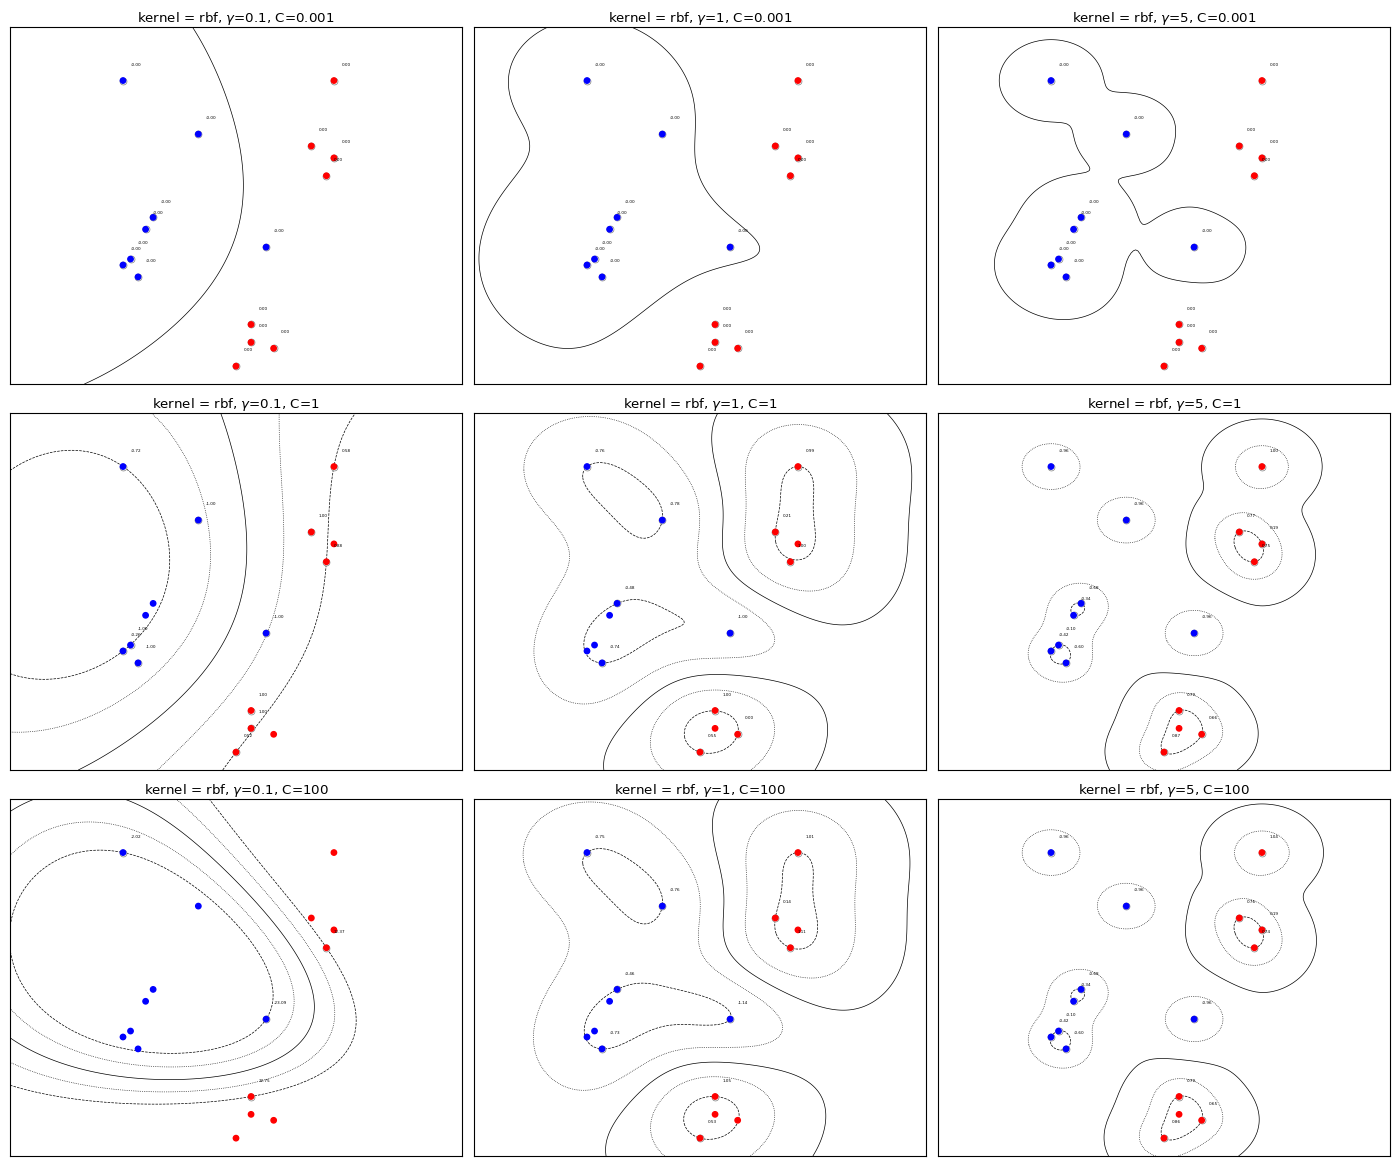

In [23]:
plot_svm_kernels(['rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf'],
                 gamma=[0.1,1,5,0.1,1,5,0.1,1,5],
                 C=[0.001,0.001,0.001,1,1,1,100,100,100],size=2.6)

Aperçu des kernels

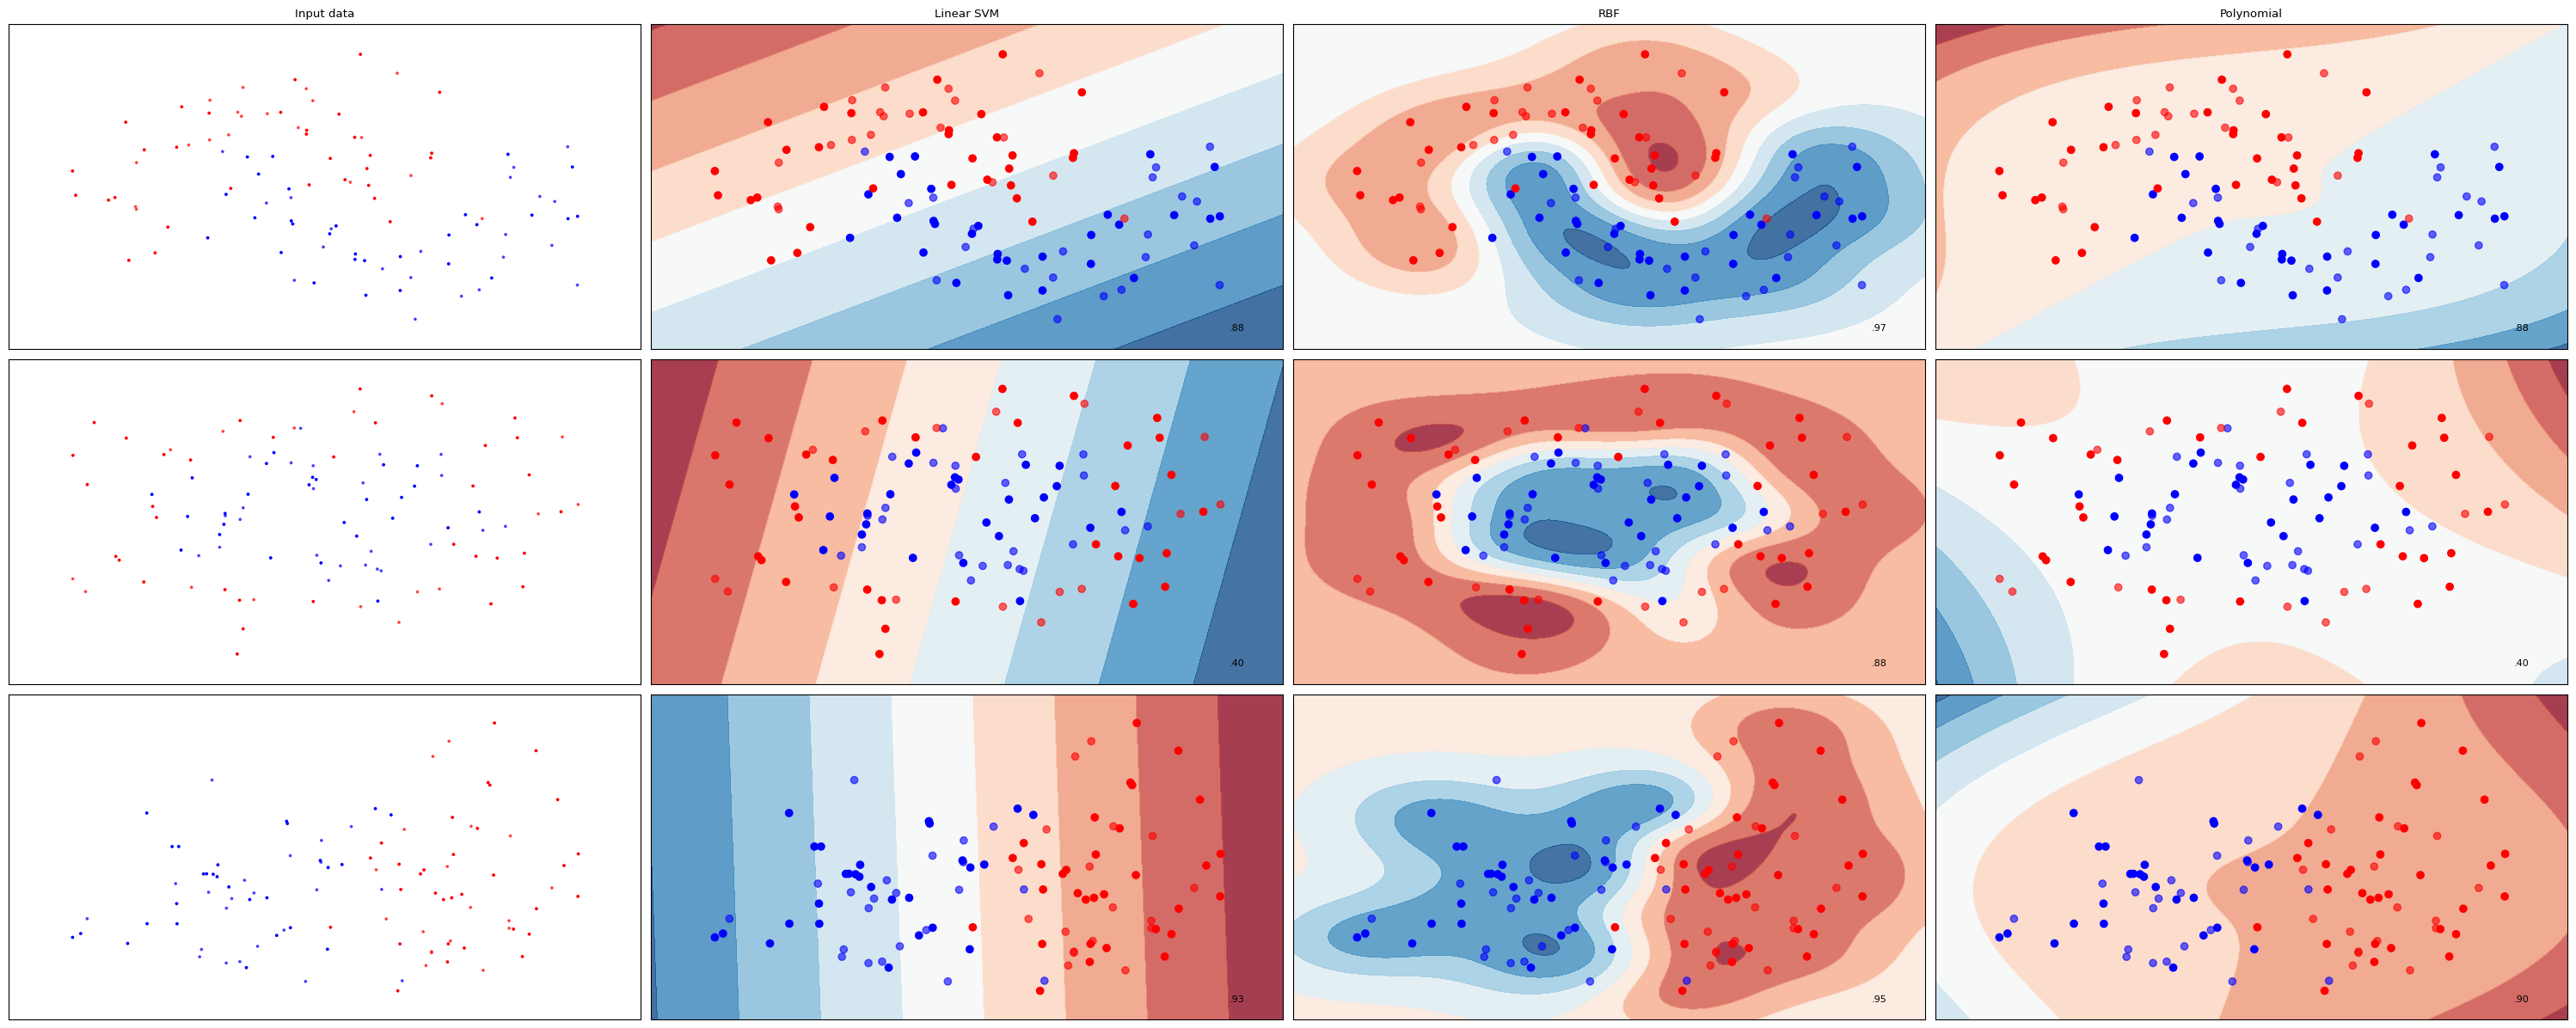

In [24]:
from sklearn.svm import SVC
names = ["Linear SVM", "RBF", "Polynomial"]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(kernel="poly", degree=3, C=0.1)
    ]
 
mglearn.plots.plot_classifiers(names, classifiers, figuresize=(20*fig_scale,8*fig_scale)) 

### Les SVM en pratique
* C et gamma doivent _toujours_ être ajustés 
    * Régularisateurs interactifs. Trouver un bon C, puis ajuster finement le gamma.
* Les SVM s'attendent à ce que toutes les caractéristiques soient approximativement à la même échelle.
    * Les données doivent être mises à l'échelle au préalable
* Permet d'apprendre des limites de décision complexes, même avec peu de caractéristiques
    * Fonctionne bien avec des données de faible et de haute dimension
    * Les données doivent être mises à l'échelle au préalable.
* Difficile à inspecter, bien que les vecteurs de support puissent l'être.
* Dans sklearn, vous pouvez utiliser `SVC` pour la classification avec une gamme de kernels
    * `SVR` pour la régression

### Autres kernels
* Il existe de nombreux autres kernels possibles
* Si aucune fonction kernel n'existe, nous pouvons toujours _précalculer_ la matrice du kernel.
    * Tout ce dont vous avez besoin, c'est d'une mesure de similarité, et vous pouvez utiliser les SVM.
* Kernels de texte : 
    * Kernels de mots : construire une représentation du texte sous forme de sac de mots (par exemple TFIDF).
        * Le kernel est le produit intérieur entre ces vecteurs.
    * Kernels de séquences : les séquences sont similaires si elles partagent de nombreuses sous-séquences.
        * Construire une matrice de kernel basée sur les similarités par paire
* Kernels de graphe : Même idée (par exemple, trouver des sous-graphes communs pour mesurer la similarité).
* De nos jours, les kernels d'apprentissage profond sont plus fréquemment utilisés.

## Le théorème du représentant (Representer Theorem)
* Nous pouvons également kernéliser de nombreuses autres fonctions de perte
* Le _Théorème du représentant_ stipule que si nous avons une fonction de perte $\mathcal{L}'$ avec
    * $\mathcal{L}$ une fonction de perte _arbitraire_ utilisant une fonction $f$ des entrées $\mathbf{x}$
    * $\mathcal{R}$ un score de régularisation (non décroissant) (par exemple L1 ou L2) et la constante $\lambda$
$$\mathcal{\mathcal{L}'}(\mathbf{w}) = \mathcal{L}(y,f(\mathbf{x})) + \lambda \mathcal{R} (||\mathbf{w}||)$$

* Les poids $\mathbf{w}$ peuvent alors être décrits comme une combinaison linéaire des échantillons d'apprentissage :
$$\mathbf{w} = \sum_{i=1}^{n} a_i y_i f(\mathbf{x_i})$$
* Notez que c'est exactement ce que nous avons trouvé pour les SVM : $ \mathbf{w} = \sum_{i=1}^{l} a_i y_i \mathbf{mathbf{x_i}} $
* Par conséquent, nous pouvons également kernéliser la régression Ridge, la régression logistique, les perceptrons, la régression à support de vecteurs, ...

## Régression Ridge kernélisée
* La perte de régression linéaire Ridge (avec $\mathbf{x_0}=1$) :
    $$\mathcal{L}_{Ridge}(\mathbf{w}) = \sum_{i=0}^{n} (y_i-\mathbf{w}\mathbf{x_i})^2 + \lambda \| w \|^2$$ 
* Remplissage $\mathbf{w} = \sum_{i=1}^{n} \alpha_i y_i \mathbf{x_i}$ donne la formulation duale :
    $$\mathcal{L}_{Ridge}(\mathbf{w}) = \sum_{i=1}^{n} (y_i-\sum_{j=1}^{n} \alpha_j y_j \mathbf{x_i}\mathbf{x_j})^2 + \lambda \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j \mathbf{x_i}\mathbf{x_j}$$. 
* Généraliser $\mathbf{x_i}\cdot\mathbf{x_j}$ à $k(\mathbf{x_i},\mathbf{x_j})$
    $$\mathcal{L}_{KernelRidge}(\mathbf{\alpha},k) = \sum_{i=1}^{n} (y_i-\sum_{j=1}^{n}) \alpha_j y_j k(\mathbf{x_i},\mathbf{x_n}))^2 + \lambda \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j k(\mathbf{x_i},\mathbf{x_j})$$

### Exemple Ridge kernelisée
* La prédiction (rouge) est maintenant une combinaison linéaire de kernels (bleu) : $y = \sum_{j=1}^{n} \alpha_j y_j k(\mathbf{x},\mathbf{x_j})$
* Nous apprenons un coefficient dual pour chaque point

In [25]:
import scipy.stats as stats
import math

@interact
def plot_kernel_ridge(gamma=(0.1,2,0.1),a1=(-1,1,0.1),a2=(-1,1,0.1),a3=(-1,1,0.1)):
    fig, ax = plt.subplots(figsize=(10*fig_scale,5*fig_scale))
    xs = [-6,-4,-3,0,2,4]
    ys = [-0.3,0.05,-0.1,0.3,0.16,-0.05]
    alphas = [a1,a2,a3,.7,0.3,-0.2]
    p = np.linspace(-10, 10, 100)
    f = [0]*100
    for a,x,y in zip(alphas,xs,ys):
        k = stats.norm.pdf(p, x, 1/gamma)
        f += a*k
        plt.plot(p, k, 'b-', lw=1*fig_scale)
        plt.annotate("%0.2f" % (a), (x+0.1,y+0.01), fontsize=20*fig_scale, zorder=11)
    plt.plot(p, f, 'r-', lw=3*fig_scale)
    plt.scatter(xs,ys);

interactive(children=(FloatSlider(value=1.0, description='gamma', max=2.0, min=0.1), FloatSlider(value=0.0, de…

In [26]:
if not interactive:
    plot_kernel_ridge(1,-.8,.5,-0.5)

* Entraînement de nos données de régression avec `KernelRidge`.

In [27]:
from sklearn.kernel_ridge import KernelRidge

@interact
def plot_kernel_ridge(gamma=(0.01,10,0.5)):
    X, y = mglearn.datasets.make_wave(n_samples=100)
    line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

    reg = KernelRidge(kernel='rbf', gamma=gamma).fit(X, y)
    fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
    plt.plot(line, reg.predict(line), label="Kernel Ridge (RBF)", lw=2*fig_scale, c='r')

    plt.plot(X[:, 0], y, 'o', c='k')
    plt.ylabel("Regression output")
    plt.xlabel("Input feature")
    plt.legend(loc="best");

interactive(children=(FloatSlider(value=4.51, description='gamma', max=10.0, min=0.01, step=0.5), Output()), _…

In [28]:
if not interactive:
    plot_kernel_ridge(5)

### Autres méthodes kernélisées
* La même procédure peut être appliquée à la régression logistique.
* Pour les perceptrons, $\alpha \rightarrow \alpha+1$ après chaque erreur de classification
$$\mathcal{L}_{DualPerceptron}(x_i,k) = max(0,y_i \sum_{j=1}^{n} \alpha_j y_j k(\mathbf{x_j},\mathbf{x_i}))$$.
* La régression vectorielle de soutien se comporte de manière similaire à la régression de Kernel Ridge.

In [29]:
from sklearn.svm import SVR

@interact
def plot_kernel_ridge_svr(gamma=(0.01,10,0.5)):
    X, y = mglearn.datasets.make_wave(n_samples=100)
    line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

    reg = KernelRidge(kernel='rbf', gamma=gamma).fit(X, y)
    svr = SVR(kernel='rbf', gamma=gamma).fit(X, y)
    fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
    plt.plot(line, reg.predict(line), label="Kernel Ridge (RBF)", lw=2*fig_scale, c='r')
    plt.plot(line, svr.predict(line), label="Support Vector Regression (RBF)", lw=2*fig_scale, c='b')

    plt.plot(X[:, 0], y, 'o', c='k')
    plt.ylabel("Regression output")
    plt.xlabel("Input feature")
    plt.legend(loc="best");

interactive(children=(FloatSlider(value=4.51, description='gamma', max=10.0, min=0.01, step=0.5), Output()), _…

In [30]:
if not interactive:
    plot_kernel_ridge_svr(gamma=5)

## Résumé
* Les applications de caractéristiques $\Phi(x)$ transforment les caractéristiques pour créer un espace à plus haute dimension.
    * Permet l'apprentissage de fonctions non linéaires ou de frontières, mais très coûteux/lent.
* Pour certains $\Phi(x)$, nous pouvons calculer les produits points sans construire cet espace.
    * Astuce du kernel : $k(\mathbf{x_i},\mathbf{x_j}) = \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j})$ 
    * Le noyau $k$ (produit scalaire généralisé) est une mesure de similarité entre $\mathbf{x_i}$ et $\mathbf{x_j}$.
* Il existe de nombreux kernels de ce type
    * Kernel polynomial : $k_{poly}(\mathbf{x_1},\mathbf{x_2}) = (\gamma (\mathbf{x_1} \cdot \mathbf{x_2}) + c_0)^d$ 
    * Kernel RBF (gaussien) : $k_{RBF}(\mathbf{x_1},\mathbf{x_2}) = exp(-\gamma ||\mathbf{x_1} - \mathbf{x_2}|^2)$
    * Une matrice de kernel peut être précalculée en utilisant n'importe quelle mesure de similarité (par exemple pour du texte, des graphes,...).
* Toute fonction de perte dans laquelle les entrées apparaissent uniquement sous forme de produits de points peut être transformée en kernel.
    * Par exemple, pour les SVM linéaires, il suffit de remplacer le produit scalaire par le kernel de son choix.
* Le théorème du représentant indique quelles _autres_ fonctions de perte peuvent également être transformées en kernel et comment.
    * Régression Ridge, régression logistique, Perceptrons,...